# A short & practical introduction to Tensor Flow!

Part 1

Goals for today:
    - Train a multinomial Logistic Regressor with Gradient Descend
    - Train a multinomial Logistic Regressor with Stochastic Gradient Descend
    - Introduce regularization in the two models above. Select the regularization parameter via CV
    
    - Homework: Create a Neural Network with 2 layers
    
This is a personal wrap-up of all the material provided by [Google's Deep Learning course on Udacity](https://www.udacity.com/course/deep-learning--ud730), so all credit goes to them. 

Author: Pablo M. Olmos (olmos@tsc.uc3m.es)

Date: March 2017

In [9]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
from IPython.display import display, Image
import matplotlib.pyplot as plt
# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline


In [10]:
# Lets check what version of tensorflow we have installed. The provided scripts should run with tf 1.0 and above

print(tf.__version__)

1.3.0


## Loading a dataset of images of 10 letters (not MNIST)

In [11]:
pickle_file = '../../DataSets/notMNIST/notMNIST_4e3_2e3_10e3.pickle' ## Change according to the folder where you saved the dataset provided

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (4000, 28, 28) (4000,)
Validation set (2000, 28, 28) (2000,)
Test set (10000, 28, 28) (10000,)


Lets visualize some of the images ...

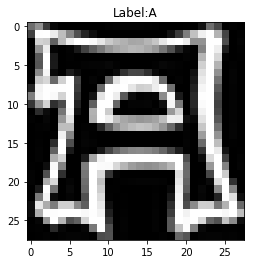

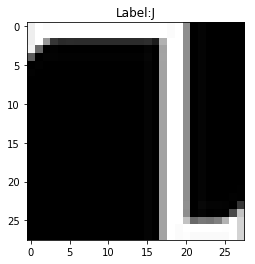

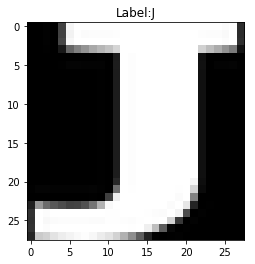

In [12]:
#Generate a random index
num_figs=3

index=np.random.randint(train_dataset.shape[0], size=num_figs)

str_labels = ['A','B','C','D','E','F','G','H','I','J']

for i in range(num_figs):
    plt.figure()
    plt.imshow(train_dataset[index[i],:,:],cmap=plt.cm.gray)
    plt.title('Label:' + str_labels[train_labels[index[i]]])

### Reformat into a shape that's more adapted to the models we're going to train, i.e.,  data as a flat matrix, labels as float 1-hot encodings.

To do this, we use the following Python trick I did not know before ... 

In [13]:
array_of_integers=np.arange(10)

print(array_of_integers)

[0 1 2 3 4 5 6 7 8 9]


In [14]:
one_hot_encoding_first_three_train_labels=array_of_integers==train_labels[0:3,None]

print(one_hot_encoding_first_three_train_labels)

[[False  True False False False False False False False False]
 [False False  True False False False False False False False]
 [False False False False False False False False  True False]]


This is very convenient!! 

To convert the image into arrays, use [numpy.reshape](http://docs.scipy.org/doc/numpy-dev/reference/generated/numpy.reshape.html#numpy.reshape)

Hint: see what the -1 does as input parameter


In [15]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    #We convert images into arrays
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    
    # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (4000, 784) (4000, 10)
Validation set (2000, 784) (2000, 10)
Test set (10000, 784) (10000, 10)


## Lets define and train a LR with tensorflow!!

We're first going to train a multinomial logistic regression using simple gradient descent. 

$$ p(y_i=1|x)=\frac{\text{e}^{(w^T_i x+b_i)}}{\sum_{j=1}^{K} \text{e}^{(w^T_j x+b_j)}}\qquad i=1,\ldots, K$$

where $x\in\mathbb{R}^D$ is the input array vector, $w_i\in\mathbb{R}^D$ for $i=1,\ldots, J$ and $b\in\mathbb{R}^J$ are the weights and biases to be estimated and $y_i$ is the output (one-hot encoded) vector, $i=1,\ldots, J$. Weight matrix $W=[w_1 w_2 \ldots w_J]_{D\times J}$ is chosen to minimize the cross-entropy loss function:

$$ L(W)=-\frac{1}{N}\sum_{n=1}^{N} \sum_{i=1}^{K}  y_i^{n} \log\left(p(y^{n}_i=1|x^n)\right)$$ 

where $(x^n,y^n)$ is the $n$-th data of the training set.


TensorFlow works like this:

    First you describe the computation that you want to see performed: what the inputs, the variables, and the operations look like. These get created as nodes over a computation graph. This description is all contained within the block below:

    with graph.as_default():
        ...

    Then you can run the operations on this graph as many times as you want by calling session.run(), providing it outputs to fetch from the graph that get returned. This runtime operation is all contained in the block below:

    with tf.Session(graph=graph) as session:
        ...

Let's load all the data into TensorFlow and build the computation graph corresponding to our training

In [16]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
train_subset = 1000

graph_LR = tf.Graph()

with graph_LR.as_default():
    
    # Input data.
    # Load the training, validation and test data into constants that are
    # attached to the graph.
    tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
    tf_train_labels = tf.constant(train_labels[:train_subset])
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)    

    # Variables.
    # These are the parameters that we are going to be training. The weight
    # matrix will be initialized using random values following a (truncated)
    # normal distribution. The biases get initialized to zero.
    weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
    
    biases = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    # We multiply the inputs with the weight matrix, and add biases. We compute
    # the softmax and cross-entropy (it's one operation in TensorFlow, because
    # it's very common, and it can be optimized). We take the average of this
    # cross-entropy across all training examples: that's our loss.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels,logits=logits))
    
    # Optimizer.
    # We are going to find the minimum of this loss using gradient descent.
    #optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Optimizer.
    # We are going to find the minimum of this loss using ADAGRAD   
    optimizer = (tf.train.AdagradOptimizer
             (learning_rate=0.05,initial_accumulator_value=0.1,use_locking=False,name='Adagrad').minimize(loss))
    
    # Predictions for the training, validation, and test data.
    # These are not part of training, but merely here so that we can report
    # accuracy figures as we train.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases) 

In [17]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
              / predictions.shape[0])

In [18]:
num_steps=3000

with tf.Session(graph=graph_LR) as session:
    
    # This is a one-time operation which ensures the parameters get initialized as
    # we described in the graph: random weights for the matrix, zeros for the
    # biases.
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        # Run the computations. We tell .run() that we want to run the optimizer,
        # and get the loss value and the training predictions returned as numpy
        # arrays.
        
        _, l, predictions = session.run([optimizer, loss, train_prediction])
        if (step % 500 == 0):
            print('Loss at step %d: %f' % (step, l))
            print('Training accuracy: %.1f%%' % accuracy(
            predictions, train_labels[:train_subset, :]))
            # Calling .eval() on valid_prediction is basically like calling run(), but
            # just to get that one numpy array. Note that it recomputes all its graph
            # dependencies.
            print('Validation accuracy: %.1f%%' % accuracy(
                valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Loss at step 0: 18.638182
Training accuracy: 13.3%
Validation accuracy: 13.1%
Loss at step 500: 1.035050
Training accuracy: 83.2%
Validation accuracy: 68.3%
Loss at step 1000: 0.487682
Training accuracy: 90.7%
Validation accuracy: 68.8%
Loss at step 1500: 0.244062
Training accuracy: 95.2%
Validation accuracy: 68.6%
Loss at step 2000: 0.128583
Training accuracy: 98.0%
Validation accuracy: 69.0%
Loss at step 2500: 0.079604
Training accuracy: 99.1%
Validation accuracy: 69.4%
Test accuracy: 75.5%


## Easy istn'it? Let's now switch to stochastic gradient descent training instead, which is much faster.

The graph will be similar, except that instead of holding all the training data into a constant node, we create a Placeholder node which will be fed actual data at every call of session.run().

In [19]:
batch_size = 128

graph_LR_SGD = tf.Graph()

with graph_LR_SGD.as_default():
    
    # Input data.
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)    

    # Variables.
    # These are the parameters that we are going to be training. The weight
    # matrix will be initialized using random values following a (truncated)
    # normal distribution. The biases get initialized to zero.
    weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    # We multiply the inputs with the weight matrix, and add biases. We compute
    # the softmax and cross-entropy (it's one operation in TensorFlow, because
    # it's very common, and it can be optimized). We take the average of this
    # cross-entropy across all training examples: that's our loss.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels,logits=logits))
    
    # Optimizer.
    # We are going to find the minimum of this loss using gradient descent.
    # optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Optimizer.
    # We are going to find the minimum of this loss using ADAGRAD   
    optimizer = (tf.train.AdagradOptimizer
             (learning_rate=0.05,initial_accumulator_value=0.1,use_locking=False,name='Adagrad').minimize(loss))
    
    # Predictions for the training, validation, and test data.
    # These are not part of training, but merely here so that we can report
    # accuracy figures as we train.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
        tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases) 

In [20]:
num_steps = 30001

with tf.Session(graph=graph_LR_SGD) as session:
    
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        
        # Generate a minibatch.
        
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        
       
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % 1000 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))

    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 17.668907
Minibatch accuracy: 7.8%
Validation accuracy: 9.6%
Minibatch loss at step 1000: 1.335656
Minibatch accuracy: 81.2%
Validation accuracy: 72.8%
Minibatch loss at step 2000: 1.184857
Minibatch accuracy: 77.3%
Validation accuracy: 73.7%
Minibatch loss at step 3000: 1.028442
Minibatch accuracy: 81.2%
Validation accuracy: 74.5%
Minibatch loss at step 4000: 0.771170
Minibatch accuracy: 87.5%
Validation accuracy: 74.6%
Minibatch loss at step 5000: 0.406287
Minibatch accuracy: 86.7%
Validation accuracy: 74.2%
Minibatch loss at step 6000: 0.610388
Minibatch accuracy: 82.0%
Validation accuracy: 74.9%
Minibatch loss at step 7000: 0.418773
Minibatch accuracy: 88.3%
Validation accuracy: 74.5%
Minibatch loss at step 8000: 0.437604
Minibatch accuracy: 88.3%
Validation accuracy: 74.7%
Minibatch loss at step 9000: 0.451682
Minibatch accuracy: 86.7%
Validation accuracy: 74.8%
Minibatch loss at step 10000: 0.456434
Minibatch accuracy: 89.8%
Validation accura

## Excelent! Now, lets introduce regularization via L2 penalization in the cost function


$$ L(W)=-\frac{1}{N}\sum_{n=1}^{N} \sum_{i=1}^{K}  y_i^{n} \log\left(p(y^{n}_i=1|x^n)\right)+\beta||W||_2$$


In [21]:
batch_size = 128
beta=1.0 #Regularization parameter
graph_LR_SGD_REG = tf.Graph()

with graph_LR_SGD_REG.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    ## ATENTION HERE!!!
    tf_beta=tf.placeholder(tf.float32)
  
    # Variables.
    weights = tf.Variable(
        tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
  
    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = (tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels,logits=logits))
            +tf_beta*tf.reduce_mean(tf.nn.l2_loss(weights)))
  
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Since we will chosse $\beta$  by CV, we define a function to train de model, with $\beta$ value as input parameter

In [22]:
def train_LR_SGD_REG(mygraph,beta,num_steps):
    
    with tf.Session(graph=mygraph) as session:
        tf.global_variables_initializer().run()
        print("Reg. parameter =%r" %(beta))
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_beta: beta}
            _, l, predictions = session.run(
                [optimizer, loss, train_prediction], feed_dict=feed_dict)
        valid_accuracy,test_accuracy=accuracy(valid_prediction.eval(), valid_labels),accuracy(test_prediction.eval(), test_labels)
    return valid_accuracy,test_accuracy

In [23]:
num_steps = 5001
beta=np.logspace(-3, -1, 5) #Regularization parameter
val_performace=np.zeros(beta.shape)
test_performace=np.zeros(beta.shape) 
for i in range(beta.shape[0]):
    val_performace[i], test_performace[i]=train_LR_SGD_REG(graph_LR_SGD_REG,beta[i],num_steps)

Reg. parameter =0.001
Reg. parameter =0.0031622776601683794
Reg. parameter =0.01
Reg. parameter =0.031622776601683791
Reg. parameter =0.10000000000000001


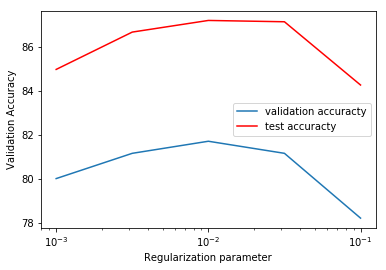

In [24]:
plt.semilogx(beta,val_performace,label='validation accuracty')
plt.semilogx(beta,test_performace,'r',label='test accuracty')
plt.xlabel('Regularization parameter')
plt.ylabel('Validation Accuracy')
plt.legend(loc=5)

In [25]:
print ("Test accuracy: %r" %(np.max(test_performace)))

betaCV=beta[np.argmax(val_performace)]

print (betaCV)

Test accuracy: 87.200000000000003
0.01


## A network with 2 dense layers

The following computation graph implements step by step a NN with two dense layer. To save lines of code, Tensor Flow provides some predefine layers that we can use. 



In [26]:
batch_size = 128
n_units=500
beta=1.0
graph_2NN = tf.Graph()

with graph_2NN.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    tf_beta=tf.placeholder(tf.float32) 
    
    # Variables.
    # We have two weight matrices and two bias vectors
    weights_1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, n_units]))
    biases_1 = tf.Variable(tf.zeros([n_units]))
    
    weights_2 = tf.Variable(
        tf.truncated_normal([n_units, num_labels]))
    biases_2 = tf.Variable(tf.zeros([num_labels]))
    
    # Training computation.
    logits_1 = tf.matmul(tf_train_dataset, weights_1) + biases_1
    
    hidden_1 = tf.nn.relu(logits_1)
    
    logits_2 = tf.matmul(hidden_1,weights_2) + biases_2
    
    loss=(tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels,logits=logits_2))
        +tf_beta*tf.reduce_mean(tf.nn.l2_loss(weights_1))
        +tf_beta*tf.reduce_mean(tf.nn.l2_loss(weights_2)))
        
        
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)    
    
    # Validation and test computation
    logits_val_1 = tf.matmul(tf_valid_dataset, weights_1) + biases_1
    
    hidden_val_1 = tf.nn.relu(logits_val_1)
    
    logits_val_2 = tf.matmul(hidden_val_1,weights_2) + biases_2   

    logits_test_1 = tf.matmul(tf_test_dataset, weights_1) + biases_1
    
    hidden_test_1 = tf.nn.relu(logits_test_1)
    
    logits_test_2 = tf.matmul(hidden_test_1,weights_2) + biases_2  
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits_2)
    valid_prediction = tf.nn.softmax(logits_val_2)
    test_prediction = tf.nn.softmax(logits_test_2)    
    

In [30]:
num_steps = 2000
beta=np.logspace(-3, -1, 5) #Regularization parameter
val_performace=np.zeros(beta.shape)
test_performace=np.zeros(beta.shape) 
for i in range(beta.shape[0]):
    val_performace[i], test_performace[i]=train_LR_SGD_REG(graph_2NN,beta[i],num_steps)

Reg. parameter =0.001
Reg. parameter =0.0031622776601683794
Reg. parameter =0.01
Reg. parameter =0.031622776601683791
Reg. parameter =0.10000000000000001


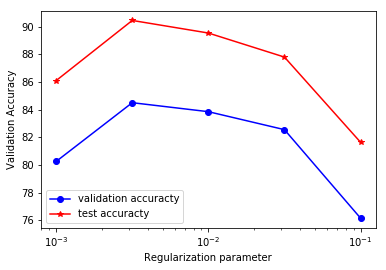

In [31]:
plt.semilogx(beta,val_performace,'-bo',label='validation accuracty')
plt.semilogx(beta,test_performace,'-r*',label='test accuracty')
plt.xlabel('Regularization parameter')
plt.ylabel('Validation Accuracy')
plt.legend()

In [32]:
print ("Test accuracy: %r" %(np.max(test_performace)))

betaCV=beta[np.argmax(val_performace)]

print (betaCV)

Test accuracy: 90.450000000000003
0.00316227766017
